This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

The train6 files were used to determine the cause of the memory leak which seems to have been using multiple workers which causes copy-on-reads to occur. setting num_wokers=0 in the dataloader resolves this issue.
See issue: https://github.com/pytorch/pytorch/issues/13246#issuecomment-905703662
blogpost: https://ppwwyyxx.com/blog/2022/Demystify-RAM-Usage-in-Multiprocess-DataLoader/

The train7 files started using datasets processed by huggingface libraries. This file continues from there.

In [1]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_30M_small_emb = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 256,
    "n_heads": 16,
    "n_layers": 18,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False
}

In [4]:
GPT_CONFIG_60M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [5]:
GPT_CONFIG_120M_DEEP = {
    "vocab_size": vocab_size,
    "context_length": 512, # this must be multiple of 64 for the flash attention implementation
    "emb_dim": 512, # this must be multiple of 16 * n_heads for the flash attention implementation
    "n_heads": 32,
    "n_layers": 28,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [6]:
GPT_CONFIG_120M_SHALLOW = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 768,
    "n_heads": 64,
    "n_layers": 10,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [7]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_120M_DEEP

In [8]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [9]:
trainer_config = {
    "dataset_scale": 1,
    "batch_size": 32 if "laptop" in hostname else 16,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 0,
    "max_lr": 1e-3,
    "compile": False # "laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [10]:
from components.gptmodel import GPTModel_v3
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L
from datasets import load_from_disk
from torch.utils.data import DataLoader


class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1

        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]
        logits = self.model([x, attn_mask])

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]

        logits = self.model([x, attn_mask])

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        self.packed_dataset = load_from_disk("packed_dataset_with_mask")
        self.packed_dataset.set_format('torch')

        self.model = GPTModel_v3(self.gpt_config)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)

        


    def train_dataloader(self):
        return DataLoader(self.packed_dataset["train"], batch_size=self.trainer_config["batch_size"], shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.packed_dataset["validation"], batch_size=self.trainer_config["batch_size"], shuffle=False)


/home/gebrial/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [12]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    logger=False,
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    gradient_clip_val=1.0,
    enable_checkpointing=True,
    # callbacks=[
    #     L.callbacks.LearningRateMonitor(logging_interval="step"),
    #     L.callbacks.ModelCheckpoint(
    #         monitor="val_loss",
    #         mode="min",
    #         save_top_k=1,
    #         filename="{epoch:02d}-{val_loss:.2f}",
    #         dirpath="./checkpoints/120M_DEEP/"
    #     )
    # ],
    precision="bf16-mixed" #"bf16-mixed", # or "transformer-engine" for 8-bit mixed
)
trainer.fit(model=litmodel)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/gebrial/projects/llm-from-scratch/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

  | Name  | Type        | Params | Mode 
----------------------------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 58909/58909 [2:39:00<00:00,  6.17it/s, accuracy_step=0.622, loss_step=1.470, val_accuracy_step=0.896, val_loss_step=0.485, val_accuracy_epoch=0.657, val_loss_epoch=1.290, accuracy_epoch=0.558, loss_epoch=2.030]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 58909/58909 [2:39:03<00:00,  6.17it/s, accuracy_step=0.622, loss_step=1.470, val_accuracy_step=0.896, val_loss_step=0.485, val_accuracy_epoch=0.657, val_loss_epoch=1.290, accuracy_epoch=0.558, loss_epoch=2.030]
CPU times: user 4h 15min 34s, sys: 15min 45s, total: 4h 31min 19s
Wall time: 2h 39min 5s


In [25]:
trainer.save_checkpoint(
    "./checkpoints/120M_DEEP_bf16_one_epoch.ckpt",
)

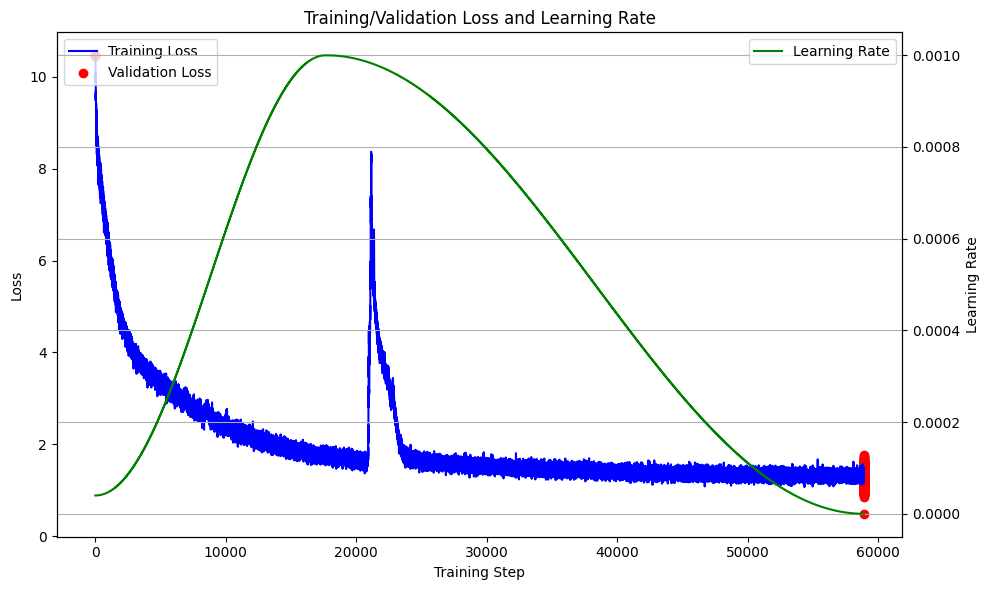

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

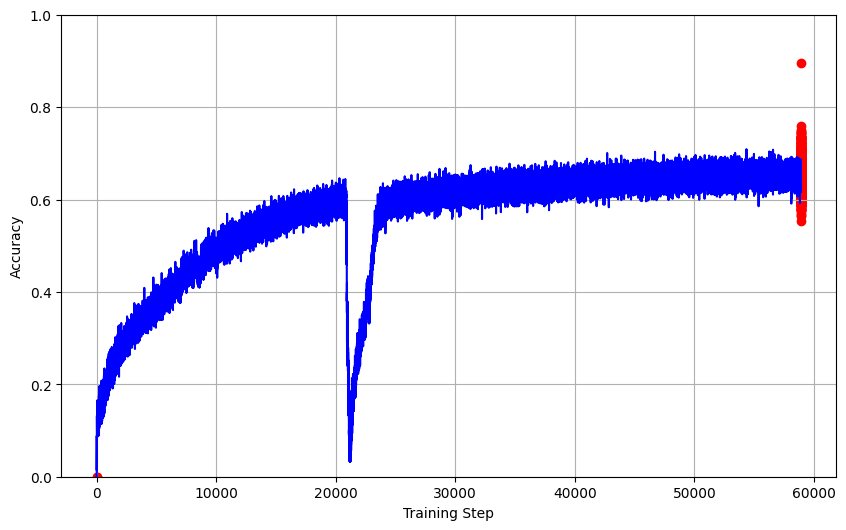

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [16]:
from tokenizers import Tokenizer

In [17]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [18]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

GPTModel_v3(
  (tok_emb): Embedding(30002, 512)
  (pos_emb): Embedding(512, 512)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock_v3(
      (att): MultiHeadAttention_v3(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock_v3(
     

In [20]:
sum([p.numel() for p in litmodel.model.parameters() if p.requires_grad])

119208960

In [21]:
from components.generatetext import generate_text_with_attn

In [22]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is too hot and the soup spills. " Oh no! What have we eaten? The water and water and soup are too hot. What should we eat?" Tom says, looking at Jane with a sad face. Jane looks at Tom and sees that she is sad too, because she wanted a soup too much and she wanted to share. Tom feels a little guilty, too, because his mom and mom always tell him what they want. But it ' s okay because they are friends. Tom has an urge for his mom and he wants to make up with the mess they have together. But Jane ' and her mom are busy in another room and there are no food. The soup is too hot for both people. The water spills everywhere, and the soup and water spill

In [23]:
import csv
import time

with open('evaluation_prompts.csv', mode='r') as file:
    csv_reader = csv.DictReader(file)
    data = [row for row in csv_reader]  # Each row is a dictionary

data_len = len(data)
current_index = 0
# measure time
start_time = time.time()
# Modify data (e.g., change 'age' column to integers)
for row in data:
    current_index += 1
    starting_text = row['prompt']
    output_text = generate_text_with_attn(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1, output_only=True)
    row['completion'] = output_text
    if current_index % 10 == 0:
        # print prompt
        print(f"Prompt {current_index}: {starting_text}")
        # print output
        print(f"Row {current_index}: {output_text}")
        current_time = time.time()
        elapsed_time = current_time - start_time
        time_left = (data_len - current_index) * (elapsed_time / current_index)
        print(f"Processed {current_index}/{data_len} rows. Estimated time left: {time_left:.2f} seconds.")


Prompt 10: One day a girl walked into the living room and noticed something very strange. There was a huge cabinet standing in the corner. It looked very old and heavy. She walked over and tried to open it, when suddenly
Row 10: the cabinet started shaking. " What ' m happening?!" the girl shouted. " The cabinet has been locked up in here!" The cabinet shook with a loud bang and a big, loud voice said : â € œ You can â €. The girl was scared, so she quickly ran away and never returned again. But then, a big man stepped in. â € œ You can open that door now! I will take you somewhere safe. You â €™ re not allowed to open the big, scary cabinet again â € he shouted and grabbed the girl â €™ s hand and dragged her to the door. The man opened and locked the door. The girl â € œ What â €™ s in here, sir? What â do I need?" she asked in fear and started to tremble again. But then she saw a big smile coming towards her. â " Don â € she thought, and the big smile disappeared and a big smile spr

In [24]:
with open('evaluation_outputs.csv', mode='w', newline='') as file:
    fieldnames = data[0].keys()  # Get column names
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(data)